In [3]:
#%pip install pytorch_tabnet
#%pip install optuna
#%pip install optuna-integration[sklearn]

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report

import torch
from sklearn.model_selection import train_test_split
from optuna import create_study
import torch.optim as optim
from optuna import create_study, samplers, pruners

# TabNet

In [4]:
# Load preprocessed and SMOTENC-applied data
X_train = pd.read_pickle('X_train_preprocessed_smotenc_df.pkl')
y_train = pd.read_pickle('y_train_smotenc.pkl')
X_test = pd.read_pickle('X_test_preprocessed.pkl')
y_test = pd.read_pickle('y_test.pkl')

# Convert data to numpy arrays (float32)
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.long)
y_test_np = y_test.values.astype(np.long)

# Split original X_train into train and validation sets (stratified)
X_train_new_np, X_val_new_np, y_train_new_np, y_val_new_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, stratify=y_train_np, random_state=42
)

In [ ]:
def objective(trial):
    # Shared value for n_d and n_a
    n_da = trial.suggest_int("n_da", 8, 32)

    params = {
        "n_d": n_da,
        "n_a": n_da,
        "n_steps": trial.suggest_int("n_steps", 2, 5),
        "gamma": trial.suggest_float("gamma", 1.0, 1.5),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 5e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128]),
        "virtual_batch_size": trial.suggest_categorical("virtual_batch_size", [32, 64])
    }

    # Initialize TabNetClassifier
    model = TabNetClassifier(
        n_d=params["n_d"],
        n_a=params["n_a"],
        n_steps=params["n_steps"],
        gamma=params["gamma"],
        lambda_sparse=params["lambda_sparse"],
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=params["lr"]),
        verbose=0,
        device_name="cuda" if torch.cuda.is_available() else "cpu"
    )

    # Train with early stopping
    model.fit(
        X_train=X_train_new_np,
        y_train=y_train_new_np,
        eval_set=[(X_val_new_np, y_val_new_np)],
        eval_metric=['logloss'],
        max_epochs=50,
        batch_size=params["batch_size"],
        virtual_batch_size=params["virtual_batch_size"],
        drop_last=False,
        patience=10
    )

    # Predict probabilities for ROC AUC
    y_proba = model.predict_proba(X_val_new_np)
    roc_auc = roc_auc_score(y_val_new_np, y_proba, multi_class='ovr', average='weighted')

    # Report metric for pruning
    trial.report(roc_auc, step=50)  # Simulate per-epoch reporting if needed

    if trial.should_prune():
        raise optuna.TrialPruned()

    return roc_auc

# Run optuna study with pruning & TPE
study = create_study(
    direction="maximize",
    sampler=samplers.TPESampler(),  # Faster convergence
    pruner=pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)
study.optimize(objective, n_trials=100)

# Print Best Hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params

[I 2025-05-14 19:18:28,097] A new study created in memory with name: no-name-0dcb02ee-9ac5-4922-af31-d8f3789d845d


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.83114


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 19:28:12,561] Trial 0 finished with value: 0.8124608635563477 and parameters: {'n_da': 25, 'n_steps': 4, 'gamma': 1.2297873573039326, 'lambda_sparse': 0.0006063522666155239, 'lr': 0.0001955798320015601, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.8124608635563477.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.41176


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 19:35:39,590] Trial 1 finished with value: 0.952825976377764 and parameters: {'n_da': 30, 'n_steps': 5, 'gamma': 1.3487623738541998, 'lambda_sparse': 0.009600468690095471, 'lr': 0.03110051484159575, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 1 with value: 0.952825976377764.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_logloss = 0.45078


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 19:40:47,250] Trial 2 finished with value: 0.9429968754477384 and parameters: {'n_da': 9, 'n_steps': 2, 'gamma': 1.3411969917056177, 'lambda_sparse': 0.00013387125592433018, 'lr': 0.002080932355910951, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 1 with value: 0.952825976377764.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.56864


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 19:49:22,085] Trial 3 finished with value: 0.9148967979359364 and parameters: {'n_da': 32, 'n_steps': 4, 'gamma': 1.0060189889465028, 'lambda_sparse': 0.003354616476776146, 'lr': 0.0004873700897296196, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 1 with value: 0.952825976377764.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.5917


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 19:55:37,978] Trial 4 finished with value: 0.904348847320853 and parameters: {'n_da': 24, 'n_steps': 3, 'gamma': 1.0993723880022745, 'lambda_sparse': 0.004637721590458607, 'lr': 0.00014263819163120355, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 1 with value: 0.952825976377764.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.40568


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 19:58:50,172] Trial 5 finished with value: 0.9544806615293938 and parameters: {'n_da': 25, 'n_steps': 2, 'gamma': 1.3720867061940019, 'lambda_sparse': 0.0009342391772113165, 'lr': 0.02451211837088084, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 5 with value: 0.9544806615293938.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.91637


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:05:48,699] Trial 6 finished with value: 0.7613898426511165 and parameters: {'n_da': 19, 'n_steps': 5, 'gamma': 1.0986714012147274, 'lambda_sparse': 0.005371951355555865, 'lr': 0.00014153098409724196, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 5 with value: 0.9544806615293938.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.84474


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:14:48,114] Trial 7 finished with value: 0.8030584906560576 and parameters: {'n_da': 29, 'n_steps': 4, 'gamma': 1.414761672775171, 'lambda_sparse': 5.171634018271245e-05, 'lr': 0.00010288082537344237, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 5 with value: 0.9544806615293938.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.38863


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:21:58,763] Trial 8 finished with value: 0.9579213444615832 and parameters: {'n_da': 27, 'n_steps': 5, 'gamma': 1.2217738558530613, 'lambda_sparse': 6.670436823999286e-05, 'lr': 0.005512492955755153, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_logloss = 0.40878


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:24:53,939] Trial 9 finished with value: 0.9544855638073659 and parameters: {'n_da': 15, 'n_steps': 2, 'gamma': 1.2442370078579033, 'lambda_sparse': 0.0005213316570138097, 'lr': 0.005527735746337963, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 8 with value: 0.9579213444615832.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.4247


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:31:31,541] Trial 10 finished with value: 0.9491627219489436 and parameters: {'n_da': 18, 'n_steps': 5, 'gamma': 1.4961770691594398, 'lambda_sparse': 1.0521814724934249e-05, 'lr': 0.005301138825783432, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_logloss = 0.41686


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:35:36,801] Trial 11 finished with value: 0.9517936722984219 and parameters: {'n_da': 13, 'n_steps': 3, 'gamma': 1.2208518478357944, 'lambda_sparse': 0.00010928757735484187, 'lr': 0.004738040009479517, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_logloss = 0.4036


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:39:46,355] Trial 12 finished with value: 0.9554976843354385 and parameters: {'n_da': 14, 'n_steps': 3, 'gamma': 1.167019680877371, 'lambda_sparse': 1.4782269780078504e-05, 'lr': 0.010254196182054271, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 8 with value: 0.9579213444615832.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_logloss = 0.42282


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:44:58,687] Trial 13 finished with value: 0.9500272986764569 and parameters: {'n_da': 8, 'n_steps': 3, 'gamma': 1.1670523265488608, 'lambda_sparse': 1.2242848179420537e-05, 'lr': 0.013544685426783843, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.48433


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:50:41,012] Trial 14 pruned. 



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.39193


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:54:45,488] Trial 15 finished with value: 0.9569783441275554 and parameters: {'n_da': 22, 'n_steps': 3, 'gamma': 1.0173284366731843, 'lambda_sparse': 3.6230606376314283e-05, 'lr': 0.01187750897964502, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.43172


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 20:59:19,982] Trial 16 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.55731


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:05:16,964] Trial 17 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_logloss = 0.39404


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:09:50,698] Trial 18 finished with value: 0.956544421859301 and parameters: {'n_da': 21, 'n_steps': 3, 'gamma': 1.0574229267714936, 'lambda_sparse': 8.332058773240836e-05, 'lr': 0.012535618347645428, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_logloss = 0.39187


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:12:58,822] Trial 19 finished with value: 0.9565800378414864 and parameters: {'n_da': 28, 'n_steps': 2, 'gamma': 1.1672185224776528, 'lambda_sparse': 2.299672840259344e-05, 'lr': 0.003413142382985263, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.68889


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:20:40,815] Trial 20 pruned. 



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.39714


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:24:36,580] Trial 21 finished with value: 0.9555959068867655 and parameters: {'n_da': 28, 'n_steps': 2, 'gamma': 1.177307091929488, 'lambda_sparse': 2.4096281909872238e-05, 'lr': 0.003468754406730844, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_logloss = 0.40275


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:28:36,126] Trial 22 finished with value: 0.9554505887517438 and parameters: {'n_da': 23, 'n_steps': 2, 'gamma': 1.1428918457598765, 'lambda_sparse': 2.5680041120414844e-05, 'lr': 0.008830764626292923, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.39998


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:34:26,497] Trial 23 finished with value: 0.9560116421977138 and parameters: {'n_da': 26, 'n_steps': 3, 'gamma': 1.1997972251050986, 'lambda_sparse': 6.8150543629281e-05, 'lr': 0.0030249547183872436, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9579213444615832.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.3929


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:37:36,062] Trial 24 finished with value: 0.9582125186582119 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.2894982957578571, 'lambda_sparse': 2.4915207964741674e-05, 'lr': 0.0074817571437348985, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_logloss = 0.39323


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:41:18,357] Trial 25 finished with value: 0.9565713794452676 and parameters: {'n_da': 32, 'n_steps': 3, 'gamma': 1.2873254601349842, 'lambda_sparse': 0.00013758359868794233, 'lr': 0.020870990050135232, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.40312


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:46:32,862] Trial 26 finished with value: 0.9544912106383714 and parameters: {'n_da': 31, 'n_steps': 4, 'gamma': 1.4522168670526587, 'lambda_sparse': 2.7647889005357473e-05, 'lr': 0.007543569161381109, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.40064


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:48:49,635] Trial 27 finished with value: 0.9559539761797875 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.3164856587247493, 'lambda_sparse': 5.587528769802045e-05, 'lr': 0.020439892526192414, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.41295


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 21:51:26,102] Trial 28 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.61409


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:00:00,314] Trial 29 pruned. 



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_logloss = 0.39961


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:02:52,893] Trial 30 finished with value: 0.9561528616088786 and parameters: {'n_da': 23, 'n_steps': 2, 'gamma': 1.0011277964442127, 'lambda_sparse': 0.0009316731795527947, 'lr': 0.007035972877831834, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_logloss = 0.39623


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:06:23,276] Trial 31 finished with value: 0.9568113841850349 and parameters: {'n_da': 28, 'n_steps': 2, 'gamma': 1.211177962199081, 'lambda_sparse': 3.207787801446876e-05, 'lr': 0.003242468230192934, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.39089


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:09:56,247] Trial 32 finished with value: 0.9576374779511909 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.3203428661246575, 'lambda_sparse': 3.6653497603890604e-05, 'lr': 0.00221979974337764, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.39583


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:13:28,732] Trial 33 finished with value: 0.9571900600839356 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.3270195682406554, 'lambda_sparse': 7.393976908380391e-05, 'lr': 0.002063417652195455, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_logloss = 0.41899


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:17:40,720] Trial 34 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_logloss = 0.40783


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:22:51,165] Trial 35 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.50318


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:26:23,376] Trial 36 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_val_0_logloss = 0.39319


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:30:04,082] Trial 37 finished with value: 0.957694196998806 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.2632411049622372, 'lambda_sparse': 7.221704981672285e-05, 'lr': 0.0019816293487202484, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_logloss = 0.4839


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:40:33,419] Trial 38 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.47142


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:44:04,363] Trial 39 pruned. 



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_logloss = 0.39912


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:47:23,879] Trial 40 finished with value: 0.9558824620237882 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.2377584470694665, 'lambda_sparse': 0.00019285833298719353, 'lr': 0.0025387000488770292, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_logloss = 0.39539


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:50:37,785] Trial 41 finished with value: 0.9571890968788999 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.3242463027593883, 'lambda_sparse': 8.102895458074454e-05, 'lr': 0.004293589113369966, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_logloss = 0.40045


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:54:13,595] Trial 42 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_logloss = 0.39802


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 22:57:56,050] Trial 43 finished with value: 0.956213948792273 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.3504352355404137, 'lambda_sparse': 0.00010908791738140334, 'lr': 0.0015093460678585946, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 24 with value: 0.9582125186582119.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.50504


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:01:07,336] Trial 44 pruned. 



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.38498


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:04:12,029] Trial 45 finished with value: 0.9592950418985638 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.4302618139294443, 'lambda_sparse': 2.064893009732208e-05, 'lr': 0.005264687462266237, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 45 with value: 0.9592950418985638.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.42188


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:08:20,528] Trial 46 pruned. 



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_logloss = 0.3827


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:12:52,651] Trial 47 finished with value: 0.9595974311413401 and parameters: {'n_da': 27, 'n_steps': 3, 'gamma': 1.4714913384149484, 'lambda_sparse': 1.7209767321986455e-05, 'lr': 0.004776108188662292, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.39916


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:18:41,379] Trial 48 pruned. 



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.39331


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:22:04,551] Trial 49 finished with value: 0.9571530473725592 and parameters: {'n_da': 24, 'n_steps': 3, 'gamma': 1.4329793176592753, 'lambda_sparse': 1.2527629119805676e-05, 'lr': 0.009694845925348071, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.39818


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:30:29,101] Trial 50 finished with value: 0.9561468962097406 and parameters: {'n_da': 27, 'n_steps': 5, 'gamma': 1.4757681324484881, 'lambda_sparse': 1.4131112740237972e-05, 'lr': 0.005721080458528229, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_logloss = 0.39241


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:34:52,775] Trial 51 finished with value: 0.9572869074221357 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.401973461605809, 'lambda_sparse': 3.198325891701461e-05, 'lr': 0.00440883128909558, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_logloss = 0.39306


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:40:53,034] Trial 52 finished with value: 0.9574258643755664 and parameters: {'n_da': 31, 'n_steps': 3, 'gamma': 1.4630514250640037, 'lambda_sparse': 4.238903831867723e-05, 'lr': 0.0024922754009694087, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_logloss = 0.39756


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:44:53,811] Trial 53 finished with value: 0.9564198986820363 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.4260219953957172, 'lambda_sparse': 1.8851633054556546e-05, 'lr': 0.007227579212514872, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_logloss = 0.40095


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:49:34,585] Trial 54 pruned. 



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_logloss = 0.39197


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-14 23:53:54,380] Trial 55 finished with value: 0.9582658020161071 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.3714769374256668, 'lambda_sparse': 0.0016527561379324305, 'lr': 0.0029890356795020862, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.4346


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:01:22,032] Trial 56 pruned. 



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_logloss = 0.39248


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:05:09,760] Trial 57 finished with value: 0.9568242624897068 and parameters: {'n_da': 27, 'n_steps': 2, 'gamma': 1.4151521666198057, 'lambda_sparse': 0.0073135502227242915, 'lr': 0.005206577095575989, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.40641


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:08:31,209] Trial 58 pruned. 



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_logloss = 0.44062


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:13:52,863] Trial 59 pruned. 



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_logloss = 0.39949


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:19:13,463] Trial 60 finished with value: 0.9566869253651519 and parameters: {'n_da': 28, 'n_steps': 2, 'gamma': 1.1440485022845301, 'lambda_sparse': 0.0014031872560604534, 'lr': 0.008158393388161074, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_logloss = 0.39587


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:23:25,115] Trial 61 finished with value: 0.9566907038717356 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.3701847769840416, 'lambda_sparse': 2.368583967497805e-05, 'lr': 0.0017950252110433887, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_logloss = 0.38496


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:27:22,541] Trial 62 finished with value: 0.95950416650491 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.2224824096471627, 'lambda_sparse': 4.0074505294305776e-05, 'lr': 0.010800785934322361, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39659


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:30:12,800] Trial 63 pruned. 



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.39428


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:34:26,697] Trial 64 finished with value: 0.9567478114396778 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.1873685598593509, 'lambda_sparse': 2.068694586213707e-05, 'lr': 0.006810315967803672, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_logloss = 0.39885


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:38:42,766] Trial 65 pruned. 



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_logloss = 0.40013


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:42:39,442] Trial 66 finished with value: 0.956442422829879 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.2182295016371438, 'lambda_sparse': 0.0003344056788609754, 'lr': 0.005220846464050841, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.42384


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:51:45,168] Trial 67 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_logloss = 0.4058


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 00:57:09,123] Trial 68 pruned. 



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.39243


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:00:21,295] Trial 69 finished with value: 0.957430138423997 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.2724588475373415, 'lambda_sparse': 4.4346657845215366e-05, 'lr': 0.003762109337396367, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_logloss = 0.3981


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:03:45,117] Trial 70 finished with value: 0.9568235274635284 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.1927535642780704, 'lambda_sparse': 1.5701951839106747e-05, 'lr': 0.011085183418505515, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.41217


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:08:00,484] Trial 71 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_logloss = 0.39103


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:11:59,254] Trial 72 finished with value: 0.9585066251113695 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.3392548975231457, 'lambda_sparse': 2.768271157757458e-05, 'lr': 0.0026851923891809985, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_logloss = 0.39717


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:15:04,467] Trial 73 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_logloss = 0.40219


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:19:34,466] Trial 74 pruned. 



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.38841


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:23:08,261] Trial 75 finished with value: 0.9583471514756686 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.2784182210464314, 'lambda_sparse': 8.685666058197163e-05, 'lr': 0.008634651132779588, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.39599


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:26:30,767] Trial 76 finished with value: 0.9579878335308605 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.4128894775181893, 'lambda_sparse': 0.0004179713717786556, 'lr': 0.008266182948314027, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.41643


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:29:59,465] Trial 77 pruned. 



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.39608


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:32:54,869] Trial 78 finished with value: 0.9585323482108974 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.3760672508647447, 'lambda_sparse': 0.0002730931141634599, 'lr': 0.013972628849628426, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.38853


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:35:37,549] Trial 79 finished with value: 0.9587706792339524 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.3799105338545028, 'lambda_sparse': 0.0006836423951215427, 'lr': 0.03154289409738648, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.38946


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:37:50,964] Trial 80 finished with value: 0.9573386925582584 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.392053884068424, 'lambda_sparse': 0.0007905811032749091, 'lr': 0.02797602950351362, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.40416


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:40:47,214] Trial 81 pruned. 



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.40355


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:42:59,526] Trial 82 pruned. 



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.40435


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:45:15,796] Trial 83 pruned. 



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39228


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:48:02,003] Trial 84 finished with value: 0.9577700500603574 and parameters: {'n_da': 31, 'n_steps': 2, 'gamma': 1.4285979041302435, 'lambda_sparse': 0.0006715060735543196, 'lr': 0.01875702188929254, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.40134


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:51:15,797] Trial 85 pruned. 



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.40128


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:54:30,934] Trial 86 pruned. 



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39959


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:56:47,117] Trial 87 finished with value: 0.9570042341696601 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.3804216907956004, 'lambda_sparse': 9.552347200917159e-05, 'lr': 0.025830267070954076, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.40807


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 01:59:06,954] Trial 88 pruned. 



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_logloss = 0.41175


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:02:59,003] Trial 89 pruned. 



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.40406


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:05:13,082] Trial 90 pruned. 



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_logloss = 0.39383


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:08:47,335] Trial 91 finished with value: 0.9576435460422861 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.40842564691731, 'lambda_sparse': 0.0006239244120136225, 'lr': 0.008290688212070534, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 47 with value: 0.9595974311413401.



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.37589


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:12:09,007] Trial 92 finished with value: 0.9598412256863503 and parameters: {'n_da': 32, 'n_steps': 2, 'gamma': 1.4376532170808822, 'lambda_sparse': 0.00028980736117483255, 'lr': 0.009844234119875693, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 92 with value: 0.9598412256863503.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_logloss = 0.39677


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:15:10,054] Trial 93 pruned. 



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.3972


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:18:05,860] Trial 94 pruned. 



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_logloss = 0.38701


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:21:43,619] Trial 95 finished with value: 0.9593006094526869 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.3863392902462448, 'lambda_sparse': 0.0003120778810770545, 'lr': 0.01732593860996686, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 92 with value: 0.9598412256863503.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_logloss = 0.39165


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:24:37,146] Trial 96 finished with value: 0.9567502192148908 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.3905073078206642, 'lambda_sparse': 0.0002679209236120347, 'lr': 0.019203044456878118, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 92 with value: 0.9598412256863503.



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.42784


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:26:43,789] Trial 97 pruned. 



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_logloss = 0.39785


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:32:09,793] Trial 98 pruned. 



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_logloss = 0.39838


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-15 02:35:29,290] Trial 99 pruned. 


Best trial:
  Value: 0.9598
  Params:
    n_da: 32
    n_steps: 2
    gamma: 1.4376532170808822
    lambda_sparse: 0.00028980736117483255
    lr: 0.009844234119875693
    batch_size: 128
    virtual_batch_size: 32
Retraining best model for loss visualization...


In [8]:
# First, retrain on train/val split to extract loss history for plotting
print("Retraining best model for loss visualization...")
plot_model = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=2,
    gamma=1.4376532170808822,
    lambda_sparse=0.00028980736117483255,
    optimizer_fn=optim.Adam,
    optimizer_params=dict(lr=0.009844234119875693),
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

plot_model.fit(
    X_train=X_train_new_np,
    y_train=y_train_new_np,
    eval_set=[(X_train_new_np, y_train_new_np), (X_val_new_np, y_val_new_np)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=50,
    batch_size=128,
    virtual_batch_size=32,
    drop_last=False,
    patience=10
)

Retraining best model for loss visualization...

Early stopping occurred at epoch 46 with best_epoch = 36 and best_valid_logloss = 0.39183


/Users/atemlyakova/Documents/HSE/Master_thesis/.venv/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


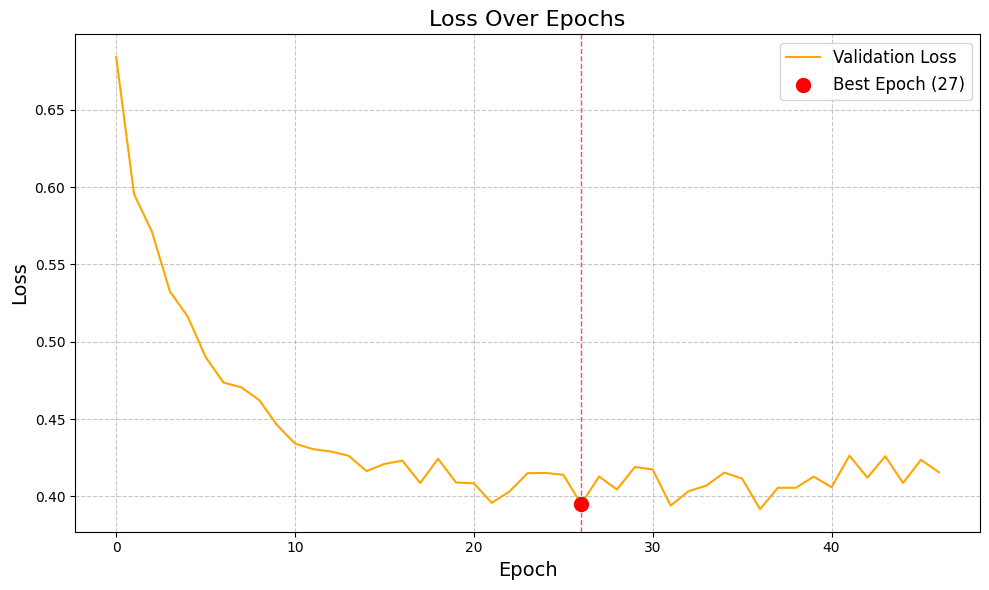

In [11]:
# Extract validation losses
valid_losses = plot_model.history['valid_logloss']

# Define the best epoch and convert to 0-based index
best_epoch = 27
best_index = best_epoch - 1  # Since Python uses 0-based indexing

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(valid_losses, label='Validation Loss', color='orange')

# Highlight the best epoch with a red dot
plt.scatter(
    best_index, 
    valid_losses[best_index], 
    color='red', 
    s=100, 
    zorder=5, 
    label=f'Best Epoch ({best_epoch})'
)

# Add a vertical dashed line at the best epoch
plt.axvline(
    x=best_index, 
    color='red', 
    linestyle='--', 
    linewidth=1, 
    alpha=0.7
)

# Add plot details
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

In [6]:
# Final training and evaluation
print("Retraining final model on full dataset...")
best_model = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=2,
    gamma=1.4376532170808822,
    lambda_sparse=0.00028980736117483255,
    optimizer_fn=optim.Adam,
    optimizer_params=dict(lr=0.009844234119875693),
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

best_model.fit(
    X_train=X_train_np,
    y_train=y_train_np,
    max_epochs=50,
    patience=10,
    batch_size=128,
    virtual_batch_size=32,
    drop_last=False
)

# Evaluate on Test Set
y_pred = best_model.predict(X_test_np)
y_proba = best_model.predict_proba(X_test_np)

roc_auc = roc_auc_score(y_test_np, y_proba, multi_class="ovr", average="weighted")
f1 = f1_score(y_test_np, y_pred, average="weighted")

print(f"Test ROC AUC (OvR weighted): {roc_auc:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

Retraining final model on full dataset...


/Users/atemlyakova/Documents/HSE/Master_thesis/.venv/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Test ROC AUC (OvR weighted): 0.8058
Test Weighted F1 Score: 0.7300


In [14]:
print("\nClassification Report:\n", classification_report(y_test_np, y_pred, digits=3))


Classification Report:
               precision    recall  f1-score   support

           0      0.851     0.822     0.836      3297
           1      0.501     0.561     0.530       982
           2      0.292     0.287     0.289       348

    accuracy                          0.726      4627
   macro avg      0.548     0.557     0.552      4627
weighted avg      0.735     0.726     0.730      4627

